In [1]:
import pandas as pd
import numpy as np
import torch
import warnings
import sys, os

sys.path.append(os.path.abspath('..'))

ais_tracks_path = '../../data/tracks_ais.csv'
cleaned_detections_path = '../../data/cleaned_data/preprocessed_radar_detections.csv'
detections_tagged_path = '../../data/detections_tagged.csv'
tracks_tagged_path = '../../data/tracks_tagged.csv'
activity_label_path = '../../data/activity_label.csv'

ais_tracks = pd.read_csv(ais_tracks_path)
radar_detections = pd.read_csv(cleaned_detections_path)
detections_tagged = pd.read_csv(detections_tagged_path)
tracks_tagged = pd.read_csv(tracks_tagged_path)
activity_label = pd.read_csv(activity_label_path)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

/Users/liuzehan/miniconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Using device: mps


In [2]:
from core.preprocess import DisruptionFilter

detections_tagged['datetime'] = pd.to_datetime(detections_tagged['cdate'] + ' ' + detections_tagged['ctime'], errors = 'coerce')
valid_detections = DisruptionFilter(detections_tagged)()

In [3]:
detections_labeled = pd.merge(valid_detections, activity_label, on = 'id_track', how = 'inner')
detections_labeled['id_track'].nunique()

2567

/Users/liuzehan/Desktop/Protected Seas/peter/core/track_plot.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime'])


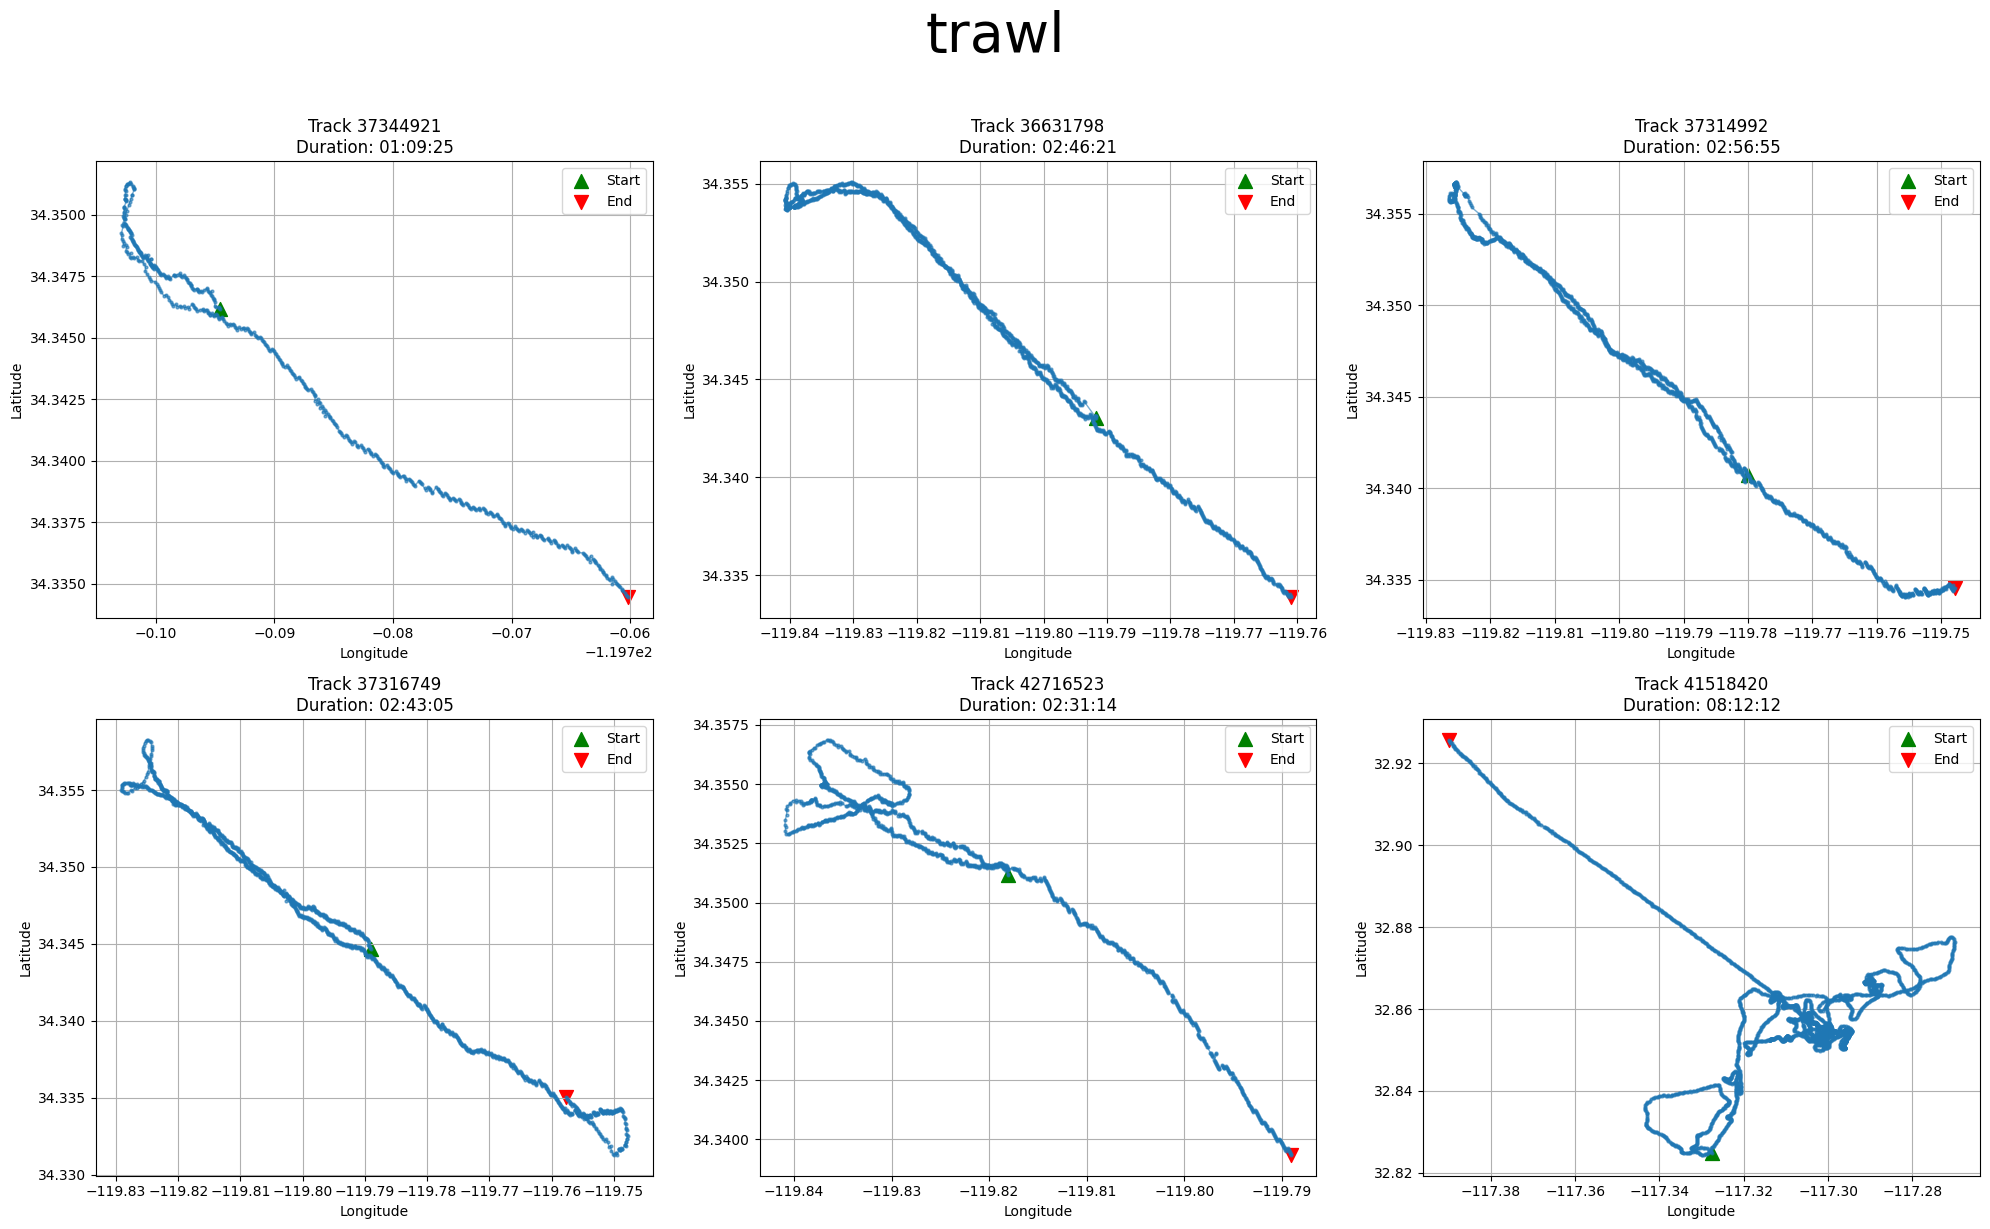

In [4]:
from core.track_plot import plot_trajectory

plot_trajectory('activity', 'trawl', detections_labeled)

In [5]:
detections_labeled.columns

Index(['id_detect', 'id_track', 'id_site', 'id_m2', 'source', 'speed',
       'course', 'assoc_str', 'assoc_id', 'confidence', 'cdate', 'ctime',
       'longitude', 'latitude', 'datetime', 'latitude_prev', 'longitude_prev',
       'time_prev', 'distance_diff', 'time_diff', 'instant_speed', 'disrupted',
       'activity'],
      dtype='object')

In [6]:
detections_labeled['activity'].value_counts()

activity
stopped     4608145
transit      208252
lobster       93036
hook          74490
drifting      71148
fishing       67969
trawl         51106
seine         42278
Name: count, dtype: int64

In [7]:
from core.sum_stats import SumStats

detections_labeled_sumstats = SumStats(detections_labeled)()

In [9]:
detections_labeled_sumstats.columns

Index(['id_track', 'duration', 'p95_speed', 'p5_speed', 'med_speed',
       'curviness', 'heading_mean', 'heading_std', 'turning_mean',
       'turning_std', 'distance_total', 'distance_o', 'detections',
       'activity'],
      dtype='object')

In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

features_subset = ['p95_speed', 'p5_speed', 'med_speed',
       'curviness', 'heading_mean', 'heading_std', 'turning_mean',
       'turning_std', 'distance_total', 'distance_o']

# Prepare features and target
X = detections_labeled_sumstats[features_subset]
y = detections_labeled_sumstats['activity']

#Type to number mapping
type2num, num2type = {}, {}
num = 0
for type in y.unique():
    type2num[type] = num
    num2type[num] = type
    num += 1
y_numeric = y.map(type2num)

# Train-test split (80:20), stratified sampling by vessel type
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, stratify=y_numeric, random_state=42)

# Define XGBoost model
model = xgb.XGBClassifier(
    objective='multi:softmax',  # Use 'multi:softprob' if you want probability outputs
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    random_state=42
)

# Hyperparameter tuning (after a few tries)
param_grid = {
    'max_depth': [13],
    'learning_rate': [0.15],
    'n_estimators': [200]
}

# Perform 4-fold cross-validation with grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=4,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)


grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))
best_model = grid_search.best_estimator_

# Make predictions on test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("\nTest Set Accuracy: {:.4f}".format(test_accuracy))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'learning_rate': 0.15, 'max_depth': 13, 'n_estimators': 200}
Best cross-validation accuracy: 0.9084

Test Set Accuracy: 0.9300


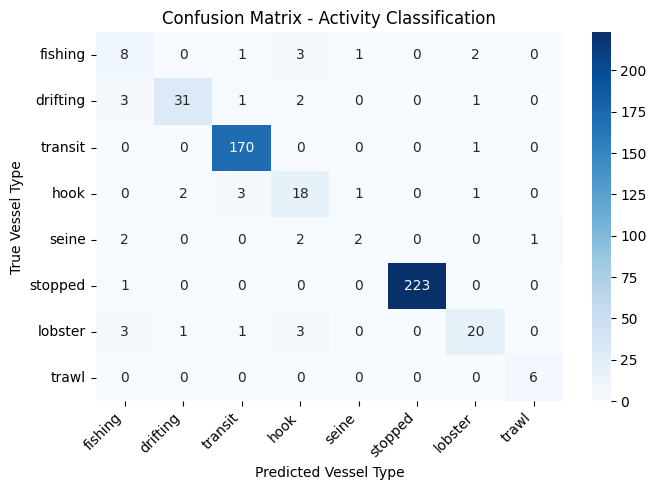

In [21]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure with a larger size
plt.figure(figsize=(7, 5))

# Create heatmap of confusion matrix
sns.heatmap(cm, 
            annot=True,  # Show numbers in cells
            fmt='d',     # Format as integers
            cmap='Blues',  # Use blue color scheme
            xticklabels=list(type2num.keys()),  # Use vessel type names for x-axis
            yticklabels=list(type2num.keys()))  # Use vessel type names for y-axis

# Customize the plot
plt.title('Confusion Matrix - Activity Classification')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff

# Show the plot
plt.show()

# Print classification report for detailed metrics
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=list(ship2num.keys())))

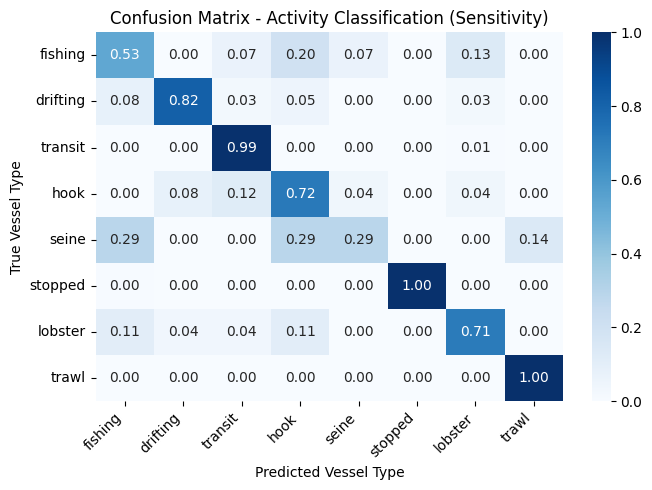

In [22]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate sensitivity (recall) for each class
sensitivity = cm.diagonal() / cm.sum(axis=1)

# Create a figure with a larger size
plt.figure(figsize=(7, 5))

# Create a matrix where each row is normalized by the sum of that row
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# Create heatmap of normalized confusion matrix
sns.heatmap(cm_normalized, 
            annot=True,  # Show numbers in cells
            fmt='.2f',   # Format as percentages
            cmap='Blues',  # Use blue color scheme
            xticklabels=y.unique(),  # Use vessel type names for x-axis
            yticklabels=y.unique())  # Use vessel type names for y-axis

# Customize the plot
plt.title('Confusion Matrix - Activity Classification (Sensitivity)')
plt.xlabel('Predicted Vessel Type')
plt.ylabel('True Vessel Type')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent label cutoff